In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [6]:
print(train_size)
print(test_size)

1728
192


In [7]:
print(train_data.shape)
print(test_data.shape)


(1728, 1)
(192, 1)


In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [12]:
print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [13]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 0.0486 - val_loss: 0.0302
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0184 - val_loss: 0.0266
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0168 - val_loss: 0.0265
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0152 - val_loss: 0.0264
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0147 - val_loss: 0.0259
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0139 - val_loss: 0.0259
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0140 - val_loss: 0.0262
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0127 - val_loss: 0.0266
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0129 - val_loss: 0.0275
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0138 - val_loss: 0.0297
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0135 - val_loss: 0.0278
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/ste

In [15]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [17]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 13.836234858981973
Testing MAPE: 12.941499215865774
Testing MAE: 11.318288311362267


In [18]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [19]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=132
i=0
while(i<90):

    if(len(temp_input)>132):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.41797003]
133
1 day input [0.51627907 0.31162791 0.40930233 0.53023256 0.51162791 0.40465116
 0.53488372 0.73488372 0.80465116 0.78139535 0.66511628 0.28837209
 0.26976744 0.29767442 0.35813953 0.34418605 0.26511628 0.29302326
 0.65116279 0.41395349 0.51627907 0.28372093 0.26511628 0.37209302
 0.53953488 0.40465116 0.30697674 0.25581395 0.33953488 0.35348837
 0.31627907 0.4372093  0.16744186 0.16744186 0.27906977 0.20930233
 0.39069767 0.24651163 0.20465116 0.38139535 0.58139535 0.66511628
 0.90697674 0.76744186 0.6        0.78139535 0.70697674 0.29302326
 0.33488372 0.67906977 0.53953488 0.37674419 0.49767442 0.33023256
 0.3627907  0.30697674 0.29302326 0.4        0.59534884 0.51162791
 0.34418605 0.3255814  0.3255814  0.33023256 0.42325581 0.40465116
 0.4744186  0.46976744 0.49767442 0.53953488 0.46976744 0.51162791
 0.45581395 0.31162791 0.28372093 0.29302326 0.2        0.35813953
 0.45116279 0.39069767 0.3255814  0.24651163 0.28837209 0.10232558
 0.74418605 0.11162791 0

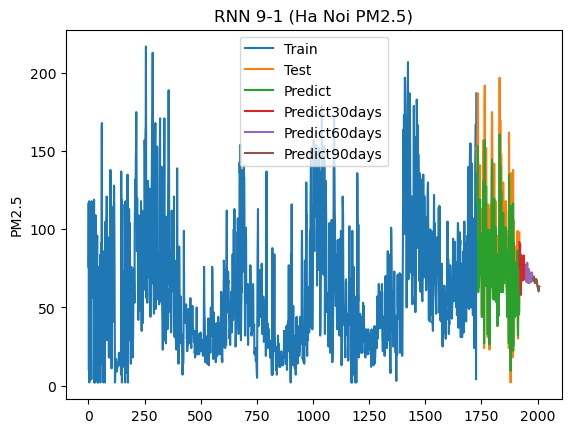

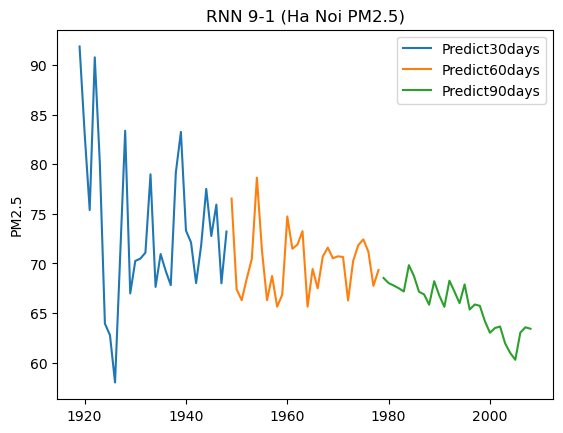

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('RNN 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('RNN 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [21]:
print(scaler.inverse_transform(lst_output))

[[91.86355677]
 [83.1127837 ]
 [75.38048905]
 [90.77012342]
 [80.089104  ]
 [63.93050563]
 [62.76304004]
 [57.9965077 ]
 [70.56731653]
 [83.36462405]
 [66.97397169]
 [70.24907526]
 [70.4839806 ]
 [71.085145  ]
 [78.97883174]
 [67.62992662]
 [70.94146964]
 [69.24764079]
 [67.80724135]
 [79.15417296]
 [83.25465855]
 [73.30094796]
 [72.11201724]
 [68.01252481]
 [71.8215653 ]
 [77.50724059]
 [72.75815588]
 [75.92408848]
 [67.99230275]
 [73.20724469]
 [76.52922553]
 [67.38976073]
 [66.29084897]
 [68.46822616]
 [70.460747  ]
 [78.64045811]
 [71.28938404]
 [66.29585323]
 [68.7322728 ]
 [65.63272831]
 [66.83735099]
 [74.73033291]
 [71.48026985]
 [71.8849611 ]
 [73.25303909]
 [65.64158347]
 [69.43614301]
 [67.48446998]
 [70.69592145]
 [71.58837718]
 [70.51765841]
 [70.71542588]
 [70.64304036]
 [66.27102417]
 [70.2500492 ]
 [71.82089892]
 [72.42160839]
 [71.18578759]
 [67.730896  ]
 [69.3344624 ]
 [68.5292576 ]
 [68.01506218]
 [67.77023163]
 [67.49336359]
 [67.16868278]
 [69.81989455]
 [68.72234